In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
import timm
from PIL import Image
import numpy as np
from torchvision import transforms

In [2]:
class ConvNeXtTransformer_concatGAP(nn.Module):
    def __init__(self, num_classes, nhead=8, dim_feedforward=4096, num_transformer_layers=1):
        super(ConvNeXtTransformer_concatGAP, self).__init__()
        self.features = timm.create_model('convnextv2_large.fcmae_ft_in22k_in1k_384', pretrained=True, num_classes=0, global_pool='')
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)
        d_model = 1536
        self.layer_norm = nn.LayerNorm(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_transformer_layers, norm=nn.LayerNorm(d_model), enable_nested_tensor=False)
        self.classifier = nn.Linear(d_model*2, num_classes)
    
    def forward(self, x):
        self.saved_activations = {}
        x = self.features(x)
        # print(x.shape)
        self.saved_activations['convnext'] = x
        x_head = self.gap(x)
        # print(x_head.shape)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        x = self.layer_norm(x)
        x = self.transformer_encoder(x)
        self.saved_activations['transformer'] = x
        x = x.permute(0, 2, 1)
        # self.saved_activations['transformer'] = x.permute(0, 2, 1)
        x = torch.mean(x, dim=2)
        x = torch.cat((x_head.view(1, 1536), x), dim=1)
        x = self.classifier(x)
        return x


def load_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    return transform(img).unsqueeze(0)

def display_heatmap(original_img, heatmap, alpha=0.5):
    """
    显示原始图像与热图的叠加效果。
    参数:
    - original_img: PIL.Image 或 numpy array，原始图像。
    - heatmap: numpy array，热图数据。
    - alpha: float，热图的透明度。
    """
    # 如果original_img是PIL.Image，转换为numpy array
    if isinstance(original_img, Image.Image):
        original_img = np.array(original_img)
    
    # 确保热图的尺寸与原图相同
    heatmap_resized = np.uint8(255 * heatmap)  # 转换为0-255范围
    heatmap_resized = plt.cm.jet(heatmap_resized)[:, :, :3]  # 应用颜色映射
    heatmap_resized = np.uint8(heatmap_resized * 255)  # 再次转换为0-255范围
    heatmap_resized = Image.fromarray(heatmap_resized).resize(original_img.shape[1::-1], Image.BILINEAR)

    # 创建图像显示
    fig, ax = plt.subplots()
    ax.imshow(original_img, alpha=1.0)
    ax.imshow(heatmap_resized, alpha=alpha)  # 叠加热图
    ax.axis('off')  # 不显示坐标轴
    plt.show()


def grad_cam(model, img_tensor, target_layer_key, labels, class_index):
    model.eval()
    
    gradients = []
    def save_grads_hook(module, grad_input, grad_output):
        # print(grad_output[0].shape)
        gradients.append(grad_output[0])

    if target_layer_key == 'convnext':
        target_layer = model.features
    elif target_layer_key == 'transformer':
        target_layer = model.transformer_encoder
    hook_handle = target_layer.register_full_backward_hook(save_grads_hook)

    output = model(img_tensor)
    # probabilities = F.sigmoid(output)
    # predictions = probabilities > 0.5
    # categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    # predicted_categories = [categories[i] for i in range(len(categories)) if predictions[0, i]]
    # # print(f"Model output probabilities: {probabilities}")
    # print(f"Predicted categories: {predicted_categories}")
    
    features = model.saved_activations[target_layer_key]
    # print(features)
    features.retain_grad()

    model.zero_grad()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    # print(output.shape, labels.shape)
    # loss = loss_fn(output, labels)
    loss = sum([output[0,class_index]])
    loss.backward()

    if not gradients:
        raise ValueError("No gradients were captured - likely an issue with the backward hook.")

    if target_layer_key == 'convnext':
        reshaped_gradients = gradients[0].permute(0, 2, 3, 1).clone()
        reshaped_features = features.permute(0, 2, 3, 1).clone()
    elif target_layer_key == 'transformer':
        reshaped_gradients = gradients[0].reshape(1, 12, 12, 1536).clone()
        reshaped_features = features.reshape(1, 12, 12, 1536).clone()
    
    pooled_gradients = torch.mean(reshaped_gradients, dim=[0, 1, 2])
    for i in range(reshaped_features.shape[-1]):
        reshaped_features[0, :, :, i] *= pooled_gradients[i]
    heatmap = torch.sum(reshaped_features, dim=3).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap = (heatmap - torch.min(heatmap)) / (torch.max(heatmap) - torch.min(heatmap) + 1e-8)

    hook_handle.remove()

    return heatmap.detach().cpu().numpy()


In [33]:
import pandas as pd

df = pd.read_csv('./data/fundus/MuReD/train_data.csv')

df['num_labels'] = df.iloc[:, 1:].sum(axis=1)

images_with_four_labels = df[df['num_labels'] == 3]

selected_images = images_with_four_labels['ID']
print(selected_images.head(30))

143     48
187    104
201    122
204    125
221    146
230    162
244    185
253    197
265    213
283    234
286    240
317    286
350    330
359    343
396    394
411    419
427    441
430    444
464    496
465    497
476    519
489    542
538    607
553    622
555    625
561    633
562    634
563    635
675    804
703    843
Name: ID, dtype: object


# Fundus images in MuReD dataset

In [3]:
model_path = './saved_models/myconvnext_2layer_concatGAP_my_remedial_10_sm.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

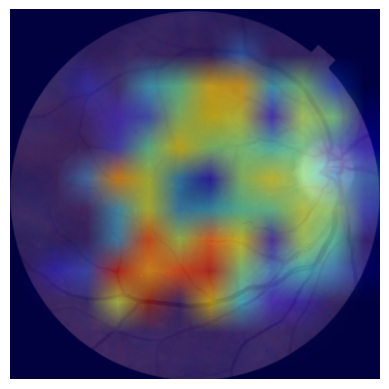

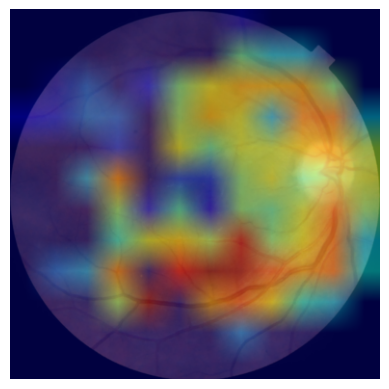

In [10]:
#### 1 label
img_tensor = load_image('./data/fundus/MuReD/images/images/988.png')
labels = torch.tensor([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 6)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 6)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

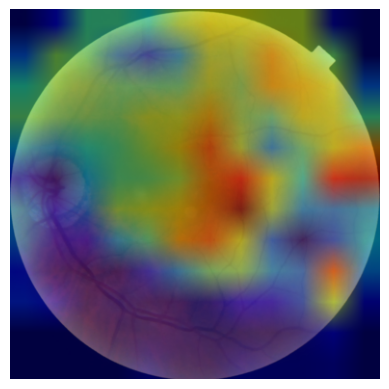

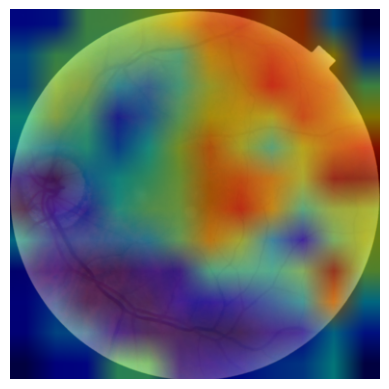

In [27]:
#### 2 label
img_tensor = load_image('./data/fundus/MuReD/images/images/1273.png')
labels = torch.tensor([0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 2)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 2)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

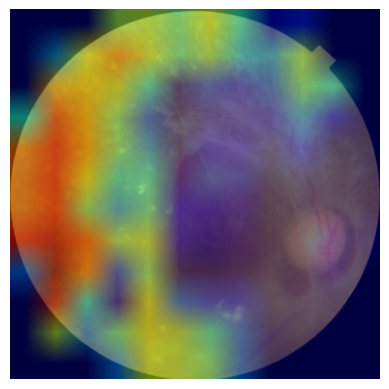

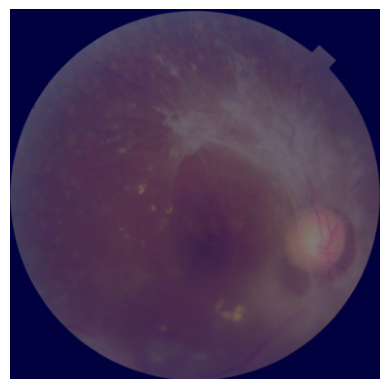

In [47]:
#### 3 label
img_tensor = load_image('./data/fundus/MuReD/images/images/496.png')
labels = torch.tensor([1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 14)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 14)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

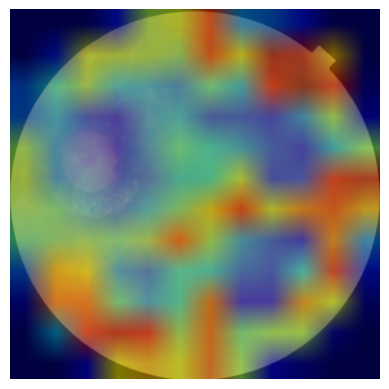

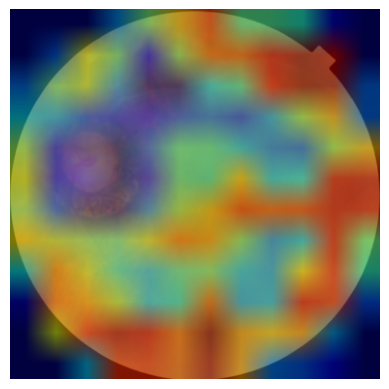

In [9]:
#### 4 label
img_tensor = load_image('./data/fundus/MuReD/images/images/980.png')
labels = torch.tensor([0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0]).unsqueeze(0).float()


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, 2)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, 2)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

# VOC 2012 dataset

In [3]:
model_path = './saved_models/myconvnext_2layer_concatGAP_voc2012.pt'
model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Attention_categories : person
(12, 12)
torch.Size([384, 384, 3])


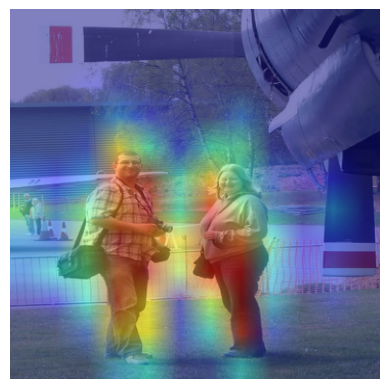

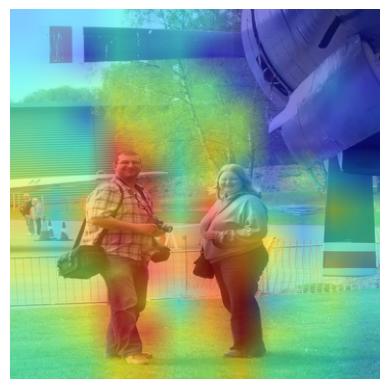

In [5]:
#### 1 label
img_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2008_005779.jpg')
labels = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]).unsqueeze(0).float()
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
GT_categories_index = [i for i in range(len(categories)) if labels[0, i]]
Attention_categories_index = GT_categories_index[0]
print(f"Attention_categories : {categories[Attention_categories_index]}")


convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, Attention_categories_index)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, Attention_categories_index)

print(convnext_heatmap.shape)
print(img_tensor.squeeze(0).permute(1, 2, 0).shape)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

Attention_categories : bottle


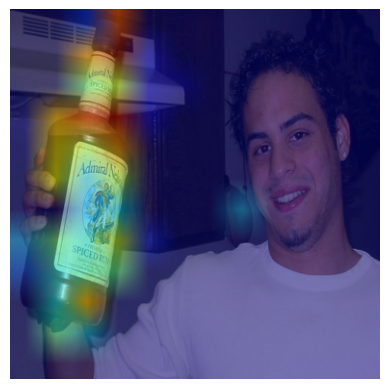

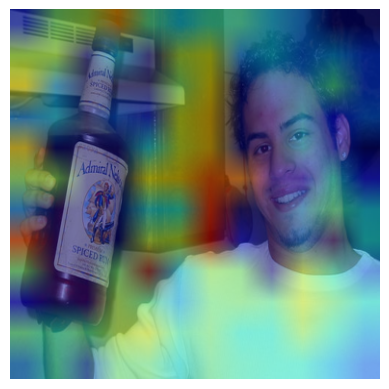

In [6]:
#### 2 label
img_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2008_003467.jpg')
labels = torch.tensor([0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]).unsqueeze(0).float()
categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
GT_categories_index = [i for i in range(len(categories)) if labels[0, i]]
Attention_categories_index = GT_categories_index[0]
print(f"Attention_categories : {categories[Attention_categories_index]}")

convnext_heatmap = grad_cam(model, img_tensor, 'convnext', labels, Attention_categories_index)
transformer_heatmap = grad_cam(model, img_tensor, 'transformer', labels, Attention_categories_index)

display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), convnext_heatmap)
display_heatmap(img_tensor.squeeze(0).permute(1, 2, 0), transformer_heatmap)

In [37]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50
# import cv2

# model_path = './saved_models/myconvnext_2layer_concatGAP_voc2012.pt'
# model = ConvNeXtTransformer_concatGAP(num_classes=20, num_transformer_layers=2)
# model_state_dict = torch.load(model_path)
# model.load_state_dict(model_state_dict)
# target_layers = [model.features]
# input_tensor = load_image('./data/voc2012/VOC2012_train_val/JPEGImages/2008_003467.jpg')
# # Note: input_tensor can be a batch tensor with several images!

# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers)

# # You can also use it within a with statement, to make sure it is freed,
# # In case you need to re-create it inside an outer loop:
# # with GradCAM(model=model, target_layers=target_layers) as cam:
# #   ...

# # We have to specify the target we want to generate
# # the Class Activation Maps for.
# # If targets is None, the highest scoring category
# # will be used for every image in the batch.
# # Here we use ClassifierOutputTarget, but you can define your own custom targets
# # That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(4)]

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# rgb_img = cv2.imread('./data/voc2012/VOC2012_train_val/JPEGImages/2008_003467.jpg')[:, :, ::-1]
# rgb_img = cv2.resize(rgb_img, (384, 384))
# rgb_img = np.float32(rgb_img) / 255

# visualization = show_cam_on_image(rgb_img, grayscale_cam)

# # You can also get the model outputs without having to re-inference
# model_outputs = cam.outputs
# cv2.imwrite("output.jpg", visualization)

(1, 12, 12)
(1, 384, 384)


True